In [1]:
import numpy as np
from scipy.linalg import expm
from functools import reduce
import matplotlib.pyplot as plt

In [3]:
def k(arrays):
    return reduce(np.kron, arrays)

def c(site):
    # ops = [np.identity(levels)]*site + [np.array([[0,0,0],[1,0,0],[0,np.sqrt(2),0]])] + [np.identity(levels)] * (N-site-1)
    # return k(ops)
    return np.array([[0,0,0],[1,0,0],[0,np.sqrt(2),0]])

def a(site):
    # ops = [np.identity(levels)]*site + [np.array([[0,1,0],[0,0,np.sqrt(2)],[0,0,0]])] + [np.identity(levels)] * (N-site-1)
    # return k(ops)
    return np.array([[0,1,0],[0,0,np.sqrt(2)],[0,0,0]])

def n(site):
    return c(site) @ a(site)

g, e, e1 = [1,0,0], [0,1,0], [0,0,1]

In [106]:
N = 4

levels=3

solution = k([[1,0,0], [0,1,0], [1,0,0], [1,0,0]]) + k([[1,0,0], [1,0,0], [0,1,0], [1,0,0]]) + k([[1,0,0], [1,0,0], [1,0,0], [0,1,0]])
solution = solution/np.linalg.norm(solution)

initial_bits = [[0,1,0]]*1 + [[1,0,0]]*3
psi0 = k(initial_bits)

H = np.matrix(c(1)@a(0) + c(2)@a(0) + c(3)@a(0))
H = H + H.H

t = np.arange(0, 5.1, 0.2)

trotter = expm(-1j * H * 0.2)

fidelity = []
psi = psi0
for i in range(len(t)):
    psi = trotter @ psi
    fidelity.append(np.abs(np.vdot(solution, psi))**2)

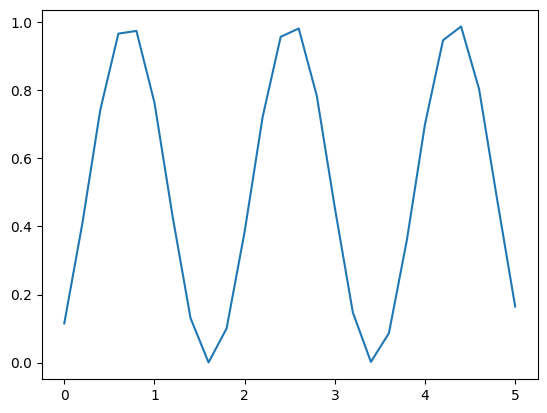

In [107]:
plt.plot(t, fidelity)

In [7]:
N = 6
levels = 3

solution = k([g, g, e, g, g, e]) + k([g, g, g, g, e1, g]) + k([g, g, g, e1, g, g])
solution = solution/np.linalg.norm(solution)

initial_bits = [e]*2 + [g]*4
psi0 = k(initial_bits)

hopping_amp = 1 # increasing hopping amplitude increases frequency
U = 0.001 # increasing on-site interaction increases prob of ground state and suppresses other states

hop = np.matrix(c(2)@a(0) + c(3)@c(3)@a(0)@a(1) + c(4)@c(4)@a(0)@a(1) + c(5)@a(1))
attract = np.matrix(n(2) @ (n(2) - 1) + n(3) @ (n(3) - 1) + n(4) @ (n(4) - 1) + n(5) @ (n(5) - 1))
repel = np.matrix(n(0) @ (n(0) - 1) + n(1) @ (n(1) - 1))
num = np.matrix(n(0) + n(1) + n(2) + n(3) + n(4) + n(5))
H = -hopping_amp * (hop + hop.H) + U * attract - U * repel - U * num

step = 0.01

t = np.arange(0, 10, step)

trotter = expm(-1j * H * step)

fidelities = [[],[],[],[],[]]
psi = psi0
for i in range(len(t)):
    # U = expm(-1j * H * t[i])
    psi = trotter @ psi
    # psi = U @ psi
    fidelities[0].append(np.abs(np.vdot(solution, psi))**2)
    fidelities[1].append(np.abs(np.vdot(k([e, e, g, g, g, g]), psi))**2)
    fidelities[2].append(np.abs(np.vdot(k([g, g, e, g, g, e]), psi))**2)
    fidelities[3].append(np.abs(np.vdot(k([g, g, g, e1, g, g]), psi))**2)
    fidelities[4].append(np.abs(np.vdot(k([g, e, e, g, g, g]), psi))**2)

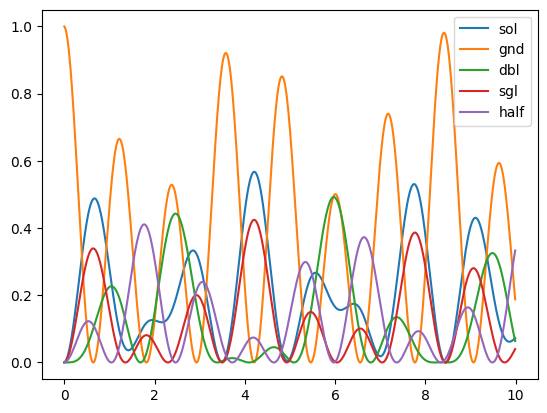

In [294]:
plt.plot(t, fidelities[0], label="sol")
plt.plot(t, fidelities[1], label="gnd")
plt.plot(t, fidelities[2], label="dbl")
plt.plot(t, fidelities[3], label="sgl")
plt.plot(t, fidelities[4], label="half")
plt.legend()

In [313]:
s = expm(-1j * H*4.5)@psi

In [314]:
for i in np.nonzero(s)[0]:
    if np.abs(s[i])**2 < 0.02:
        continue
    print(np.abs(s[i])**2)
    res = np.base_repr(i,base=3)
    print('0' * (6 - len(res)) + res)

0.4922131032730161
001001
0.4731606535371645
110000


In [278]:
N = 6

levels=3

solution = k([g,g,e,e1,g,g]) + k([g,e,g,g,e1,g]) + k([e,g,g,g,g,e1])
solution = solution/np.linalg.norm(solution)

initial_bits = [e]*3 + [g]*3
psi0 = k(initial_bits)

# if we don't exponentiate properly there is no particle number conservation
H = np.matrix(c(3)@c(3)@a(0)@a(1) + c(4)@c(4)@a(0)@a(2) + c(5)@c(5)@a(1)@a(2))
H = H + H.H
# repel = np.matrix(n(0) @ (n(0) - 1) + n(1) @ (n(1) - 1) + n(2) @ (n(2) - 1))
# H = H + 2*repel
step = 0.01
t = np.arange(0, 5.1, step)

trotter = expm(-1j * H * step)

fidelity = []
psi = psi0
for i in range(len(t)):
    psi = trotter @ psi
    fidelity.append(np.abs(np.vdot(solution, psi))**2)

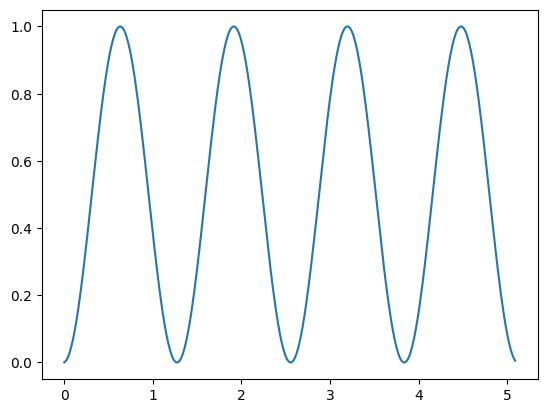

In [279]:
plt.plot(t, fidelity)

In [11]:
def gram_schmidt(v, basis):
    proj = sum([np.dot(v, b) * b for b in basis])
    # print([np.dot(v, b) * b for b in basis])
    w = v - proj
    # if v \in span(basis), we have reached dimension of Krylov subspace
    if np.linalg.norm(w) <= 0.001:
        return []
    return w / np.linalg.norm(w)

def krylovbasis(H, psi0, dim):
    kbasis = [psi0]/np.linalg.norm(psi0)
    for i in range(dim-1):
        next_v = np.dot(np.array(H), kbasis[-1])
        next_v = gram_schmidt(next_v, kbasis) # orthonormalize
        if len(next_v) == 0:
            break
        # print(next_v.shape)
        kbasis = np.append(kbasis, [next_v], axis=0)

    return kbasis

def krylov_time(psi0, H, t, krylov_dim=min(3**5, 10)):
    V = np.conj(krylovbasis(H, psi0, krylov_dim))
    V_dag = np.conj(np.transpose(V))
    T = V @ H @ V_dag
    time_ev = V_dag @ expm(complex(0, t)*T) @ V
    return time_ev

def drive_graph(V, C, E, vecs, time, sample_t, coefficient=5, psi0=[], eigenstates=False):
    initial_bits = [e]*C + [g]*V
    if len(psi0) == 0:
        psi0 = k(initial_bits)
    # print(psi0)

    hop = 0
    sites = [np.zeros((3,3))] * (V+C)
    for i in range(V):
        h = [np.identity(3)] * (V+C)
        h[C+i] = np.linalg.matrix_power(c(C+i), len(E[i]))
        for j in E[i]:
            h[j] = a(j)
            # term = term @ a(j)

        h = k(h)
        
        # sites = np.add(sites, h)
        hop += h
    # hop = k(sites)

    hop = coefficient*np.matrix(hop)
    H = hop + hop.H
    # print(H.shape)
    print("generated H")

    step = 0.05

    t = np.arange(0, time, step)

    # trotter = expm(-1j * H * step)
    trotter = krylov_time(psi0, H, step)

    print("exponentiated")

    if eigenstates == True:
        print(H.shape)
        _, v = np.linalg.eigh(np.array(H))
        vecs = np.concatenate((v[np.argsort(v.mean(axis=1))][:2], vecs))
        for eig in v:
            for j in np.nonzero(eig)[0]:
                if np.abs(eig[j])**2 < 0.02:
                    continue
                print(np.abs(eig[j])**2)
                res = np.base_repr(j,base=3)
                print('0' * (V+C - len(res)) + res)
            print()
        


    fidelities = [[] for _ in range(len(vecs))]
    psi = psi0
    for i in range(len(t)):
        psi = trotter @ psi
        # print(psi)
        if t[i] == sample_t:
            for j in np.nonzero(psi)[0]:
                if np.abs(psi[j])**2 < 0.02:
                    continue
                print(np.abs(psi[j])**2)
                res = np.base_repr(j,base=3)
                print('0' * (V+C - len(res)) + res)
        for j in range(len(vecs)):
            fidelities[j].append(np.abs(np.vdot(vecs[j], psi))**2)
        
    print("computed")
    for i in range(len(fidelities)):
        plt.plot(t, fidelities[i], label=i)
    plt.legend()

    # s = expm(-1j * H*sample_t)@psi
    # for i in np.nonzero(s)[0]:
    #     if np.abs(s[i])**2 < 0.02:
    #         continue
    #     print(np.abs(s[i])**2)
    #     res = np.base_repr(i,base=3)
    #     print('0' * (V+C - len(res)) + res)

In [16]:
import qutip

class SimpleProgressBar(qutip.ui.BaseProgressBar):
    def __init__(self):
        super().__init__()
        self.current = 0

    def start(self, iterations):
        self.total = iterations
        self.current = 0
        print("Starting simulation...")

    def update(self, progress):
        self.current += 1
        print(f"Progress: {self.current}/{self.total} ({100 * self.current / self.total:.2f}%)")

    def finished(self):
        print("Simulation completed.")

def hamiltonian(V, C, E, coefficient=5):
    # initial_bits = [e]*C + [g]*V
    H = 0
    for i in range(V):
        create_power = qutip.create(3)**len(E[i])
        h = [qutip.identity(3)] * (V+C)
        h[C+i] = create_power
        for j in E[i]:
            h[j] = qutip.destroy(3)
        if H == 0:
            H = qutip.tensor(h)
        else:
            H += qutip.tensor(h)
    H = coefficient * H
    return H + H.dag()
    

def drive_graph(V, C, E, vecs, time, sample_t, coefficient=5, psi0=[], eigenstates=False):
    # initial_bits = [e]*C + [g]*V
    # print(psi0)

    H = hamiltonian(V, C, E, coefficient=coefficient)
    # print(H.shape)
    print("generated H")

    step = 0.05

    t = np.arange(0, time, step)

    # trotter = expm(-1j * H * step)
    progress_bar = SimpleProgressBar()
    options = qutip.Options()
    options.progress_bar = progress_bar

    results = qutip.krylovsolve(H, psi0, t, krylov_dim=20, sparse=True, options=options, progress_bar=True)
    print(results)

    print("exponentiated")

    # if eigenstates == True:
    #     print(H.shape)
    #     _, v = np.linalg.eigh(np.array(H))
    #     vecs = np.concatenate((v[np.argsort(v.mean(axis=1))][:2], vecs))
    #     for eig in v:
    #         for j in np.nonzero(eig)[0]:
    #             if np.abs(eig[j])**2 < 0.02:
    #                 continue
    #             print(np.abs(eig[j])**2)
    #             res = np.base_repr(j,base=3)
    #             print('0' * (V+C - len(res)) + res)
    #         print()
        


    fidelities = [[] for _ in range(len(vecs))]
    # psi = psi0
    # for i in range(len(t)):
    #     psi = trotter @ psi
    #     # print(psi)
    #     if t[i] == sample_t:
    #         for j in np.nonzero(psi)[0]:
    #             if np.abs(psi[j])**2 < 0.02:
    #                 continue
    #             print(np.abs(psi[j])**2)
    #             res = np.base_repr(j,base=3)
    #             print('0' * (V+C - len(res)) + res)
    #     for j in range(len(vecs)):
    #         fidelities[j].append(np.abs(np.vdot(vecs[j], psi))**2)

    for i, v in enumerate(vecs):
        for s in results.states:
            fidelities[i].append(np.abs(s.overlap(v))**2)
        
    print("computed")
    for i in range(len(fidelities)):
        plt.plot(t, fidelities[i], label=i)
    plt.legend()

Chain of Atoms

generated H
Total run time:   0.04s
Result object with krylovsolve data.
------------------------------------
states = True
num_collapse = 0
exponentiated
computed


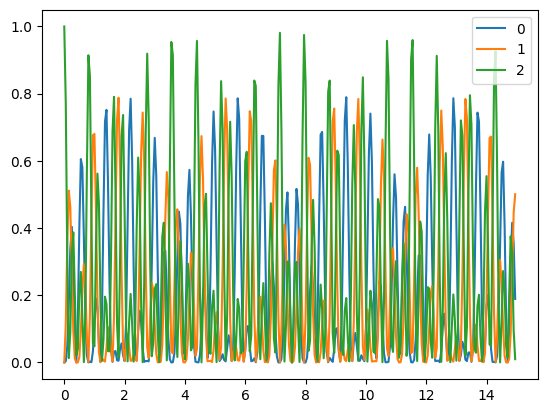

In [17]:
N=5
levels=3
drive_graph(3, 2, [[0,1], [0], [1]], [qutip.ket([0, 0, 0, 1, 1], 3), qutip.ket([0, 0, 2, 0, 0], 3), qutip.ket([1, 1, 0, 0, 0], 3)], time=15, sample_t=10, psi0=qutip.ket([1, 1, 0, 0, 0], dim=3), eigenstates=True)

generated H
Total run time:   0.26s
Result object with krylovsolve data.
------------------------------------
states = True
num_collapse = 0
exponentiated
computed


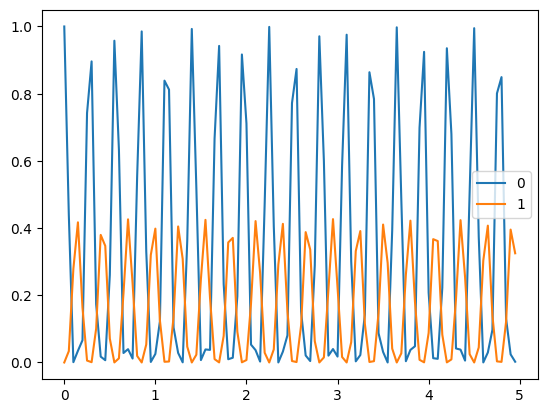

In [18]:
N=11
levels=3
psi0 = qutip.ket([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], 3)
target = (qutip.ket([0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0], 3) + qutip.ket([0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2], 3) + qutip.ket([0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2], 3) + qutip.ket([0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2], 3)).unit()
drive_graph(6, 5, [[0, 2], [0, 3], [0, 4], [1, 2], [1, 3], [1, 4]], [psi0, target], time=5, sample_t=3, psi0=psi0)

In [19]:
N=15
levels=3
psi0 = qutip.ket([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 3)
target = (qutip.ket([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2], 3) + qutip.ket([0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2], 3) + qutip.ket([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2], 3)).unit()
drive_graph(9, 6, [[0, 3], [0, 4], [0, 5], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5]], [psi0, target], time=5, sample_t=3, psi0=psi0)

generated H


KeyboardInterrupt: 

In [133]:
N=9
levels=3
drive_graph(5, 4, [[0], [0,1], [1,2], [2,3], [3]], [k([e, e, e, e, g, g, g, g, g]), k([g, g, g, g, e, g, e1, g, e]), k([g, g, g, g, g, e1, g, e1, g])], time=15, psi0=k([e, e, e, e, g, g, g, g, g]), sample_t=5, eigenstates=True)

generated H
exponentiated
(19683, 19683)


generated H
exponentiated
computed


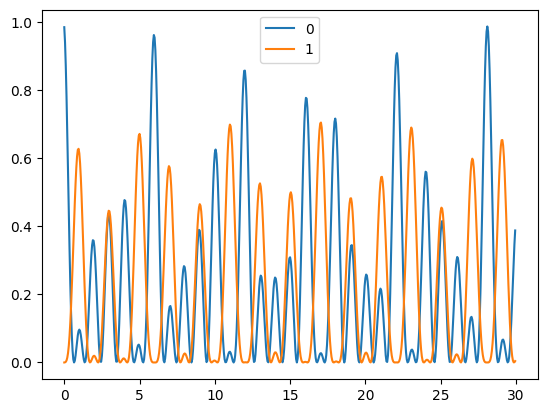

In [14]:
N=7
levels=3
drive_graph(4, 3, [[0], [0,1], [1,2], [2]], [k([e, e, e, g, g, g, g]), (1/np.sqrt(2))*(k([g, g, g, e, g, e1, g]) + k([g, g, g, g, e1, g, e]))], time=30, sample_t=5)

generated H
exponentiated
computed


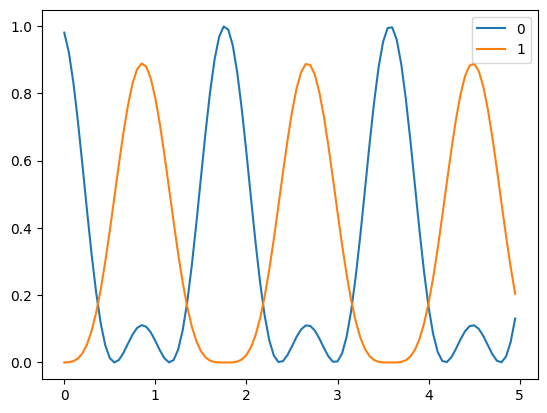

In [13]:
N=8
levels=3
drive_graph(4, 4, [[0,1], [1,2], [2,3], [3,0]], [k([e, e, e, e, g, g, g, g]), (1 / np.sqrt(2))*(k([g, g, g, g, e1, g, e1, g]) + k([g, g, g, g, g, e1, g, e1]))], time=5, sample_t=5)

generated H
exponentiated
computed


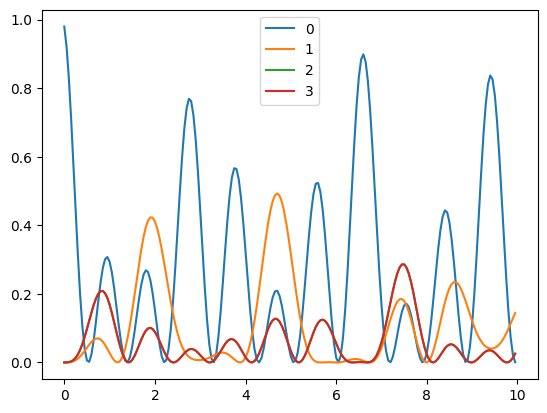

In [23]:
N=8 # kagome type lattice
levels=3
drive_graph(5, 3, [[0], [0,1], [0,2], [1], [1,2]], [k([e, e, e, g, g, g, g, g]), k([g, g, e, e, g, g, e, g]), k([g, g, g, e, g, g, g, e1]), k([g, g, g, g, g, e1, e, g])], time=10, sample_t=5)

In [5]:
N=10
levels=3
drive_graph(5, 5, [[4,0], [0,1], [1,2], [2,3], [3,4]], [k([e, e, e, e, e, g, g, g, g, g]), k([g, g, g, g, g, e1, g, e1, g, e1]), k([g, g, g, g, g, g, e1, g, e1, g])], time=8, sample_t=5)

generated H
exponentiated


KeyboardInterrupt: 

generated H
exponentiated
0.04378942752840721
00000210
0.04378942752840721
00010002
0.06747050609197339
00102000
0.5808323956046701
00110010
0.04144565888272856
01110000
0.04144565888272856
10100010
0.18099611393951798
11100000
computed


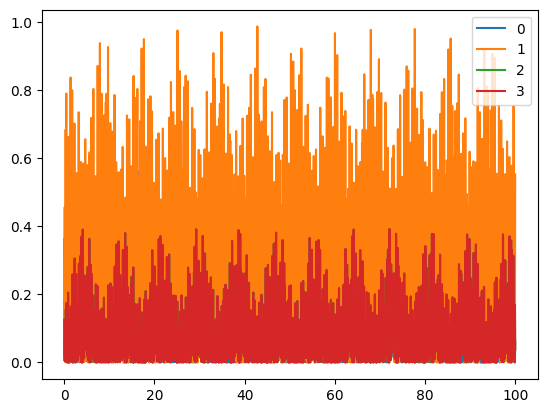

In [57]:
N=8 # kagome type lattice
levels=3
# let's use some interesting initial state
psi1 = k([g, g, e, e, g, g, e, g])
drive_graph(5, 3, [[0], [0,1], [0,2], [1], [1,2]], [k([e, e, e, g, g, g, g, g]), k([g, g, e, e, g, g, e, g]), k([g, g, g, e, g, g, g, e1]), k([g, g, g, g, g, e1, e, g])], time=100, sample_t=5, coefficient=100, psi0=psi1)

generated H
exponentiated
0.41663862301064636
00001200
0.2954791031329881
00111000
0.28788227385638343
10101000
computed


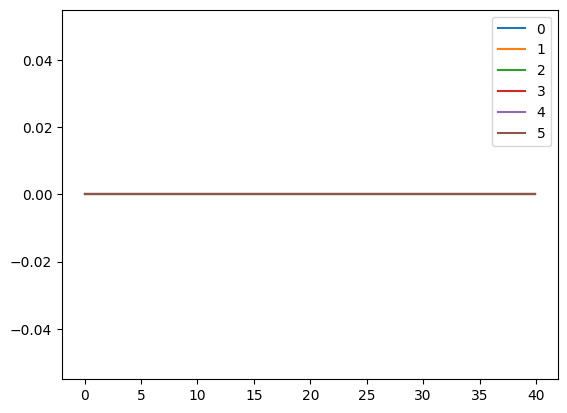

In [53]:
N=8 # kagome type lattice
# add particle conserving noise channel
levels=3
# let's use some interesting initial state
psi1 = k([g, g, e, e, e, g, g, g])
drive_graph(5, 3, [[0], [0,1], [0,2], [1], [1,2]], [k([e, e, e, g, g, g, g, g]), k([g,g,g,e1,g,g,e,g]), k([g, g, g, e, e1, g, g, g]), k([g, g, e, e, g, g, e, g]), k([g, g, g, e, g, g, g, e1]), k([g, g, g, g, g, e1, e, g])], time=40, sample_t=35, psi0=psi1)

generated H
exponentiated
computed


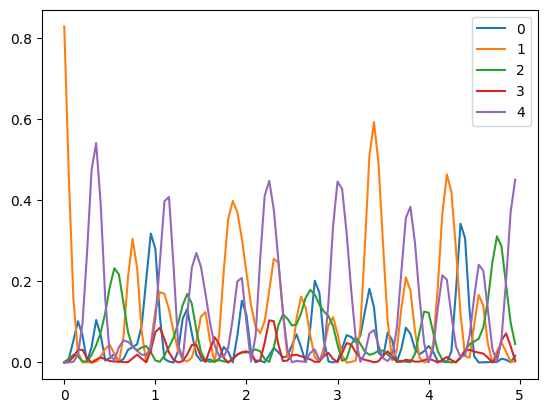

In [61]:
N=9
levels=3
# kagome minus edge
psi1 = k([g,g,g,g,g,e,e,g,e])
drive_graph(6, 3, [[0], [0,1], [0], [1], [1,2], [2]], [k([e, e, e, g, g, g, g, g, g]), k([g,g,g,g,g,e,e,g,e]), k([g,g,g,e,g,g,e,g,e]), k([g,g,g,g,e1,g,g,g,e]), k([g,g,g,e,g,g,g,e1,g])], time=5, sample_t=5, coefficient=5, psi0=psi1)

generated H
exponentiated
0.046376006960451285
000001101
0.03657966040391167
000020001
0.22581424075765014
000100020
0.04494661407709319
001100100
0.055613941472137794
010001001
0.03627987389350157
010100001
0.031748113254351416
011001000
0.13017015394025655
011100000
0.07058280300941233
100000020
0.0822932070107869
101000100
0.176707230478503
110000001
0.028942785693745678
111000000
computed


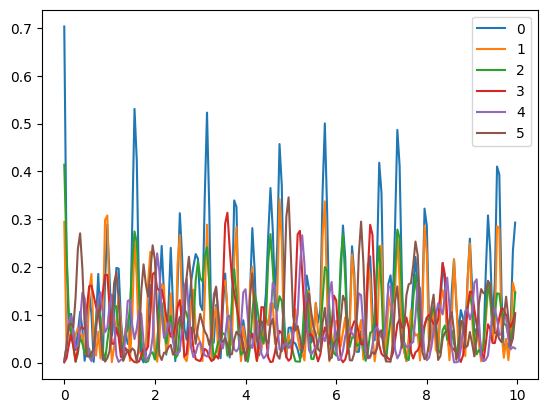

In [60]:
N=9
levels=3
# kagome minus edge
psi1 = 1/np.sqrt(2) * (k([e, e, e, g, g, g, g, g, g]) + k([g,g,g,g,g,e,e,g,e]))
drive_graph(6, 3, [[0], [0,1], [0], [1], [1,2], [2]], [psi1, k([e, e, e, g, g, g, g, g, g]), k([g,g,g,g,g,e,e,g,e]), k([g,g,g,e,g,g,e,g,e]), k([g,g,g,g,e1,g,g,g,e]), k([g,g,g,e,g,g,g,e1,g])], time=10, sample_t=5, coefficient=5, psi0=psi1)

generated H
exponentiated
computed


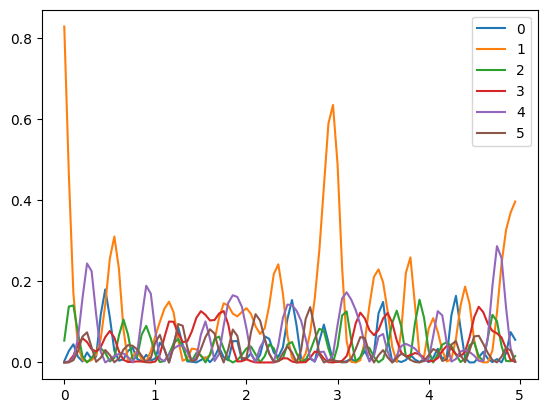

In [62]:
N=9
levels=3
# kagome minus edge
# non-maximal yet valid coloring
psi1 = k([g,g,e,g,g,e,e,g,g])
drive_graph(6, 3, [[0], [0,1], [0], [1], [1,2], [2]], [k([e, e, e, g, g, g, g, g, g]), psi1, k([g,g,g,g,g,e,e,g,e]), k([g,g,g,e,g,g,e,g,e]), k([g,g,g,g,e1,g,g,g,e]), k([g,g,g,e,g,g,g,e1,g])], time=5, sample_t=5, coefficient=5, psi0=psi1)

generated H
exponentiated
0.046403403542735956
000002100
0.13969037344448024
000101100
0.046403403542735956
000200100
0.09278209497476161
010002000
0.0923715051288632
010101000
0.09278209497476161
010200000
0.04360609021385081
100001100
0.04762718477209473
100020000
0.04360609021385081
100100100
0.027393285218406515
110001000
0.027393285218406515
110100000
0.20138835216875772
200000100
0.09761719182294654
210000000
computed


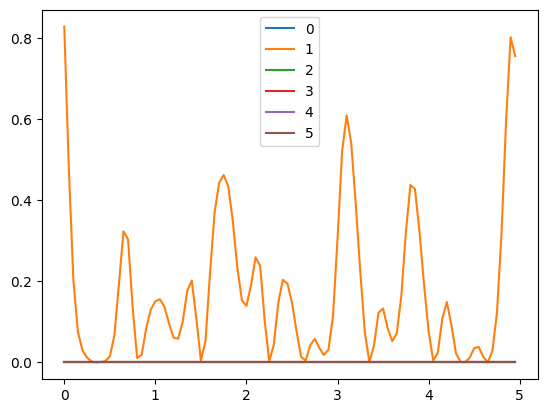

In [65]:
N=9
levels=3
# kagome minus edge
# non-maximal and invalid coloring
psi1 = k([g,g,g,e,g,e,e,g,g])
drive_graph(6, 3, [[0], [0,1], [0], [1], [1,2], [2]], [k([e, e, e, g, g, g, g, g, g]), psi1, k([g,g,g,g,g,e,e,g,e]), k([g,g,g,e,g,g,e,g,e]), k([g,g,g,g,e1,g,g,g,e]), k([g,g,g,e,g,g,g,e1,g])], time=5, sample_t=2, coefficient=5, psi0=psi1)